In [2]:
setwd("/home/pasoneto/Documents/github/doc_suomi/code")
source("utils.R")
source("data_cook.R")
setwd("/home/pasoneto/Documents/github/doc_suomi/data/interpolated")

# Nearest-neighbor interpolation

I read about different interpolation techniques that we can use in order to upsample album lengths. Here are some notes that I took to myself, but which might help you interpret the results.

- We are only upsampling the number of tracks for each album (all albums have 4 features per track, and they stay that way); 

- It's like stretching an image only in the y axis. 

- In our case, bilinear and bicubic interpolation - which interpolates between both x and y axis - become simple linear and cubic interpolations (value of the x axis doesn't affect the interpolated value on the y axis), so we don't need to worry about leakage of information between features.

- Still, using linear/cubic interpolation between two tracks in an album will cause the interpolated value to be a function of both tracks $i$ and $i+1$.

- I don't know if this is acceptable in our case, since we are mostly interested in the contrast between neighbor tracks/sections. Something to think about;

- Given this consideration, I chose to go with the simplest interpolation technique: nearest neighbors.

- This is close to - but much better than - my intuitive upsampling implementation, since interpolated cells only repeat the value that is closest on the matrix.


In [25]:
# Function receives parsed data to calculate dissim matrix
# Doesn't handle upsampling
dissim_gen = function(data){
    dt = fread(data)
    dt %<>% dplyr::select(!V1)
    colnames(dt) = c("valence", "energy", "loudness", "tempo", "album_id", "track_number")
    dt <- split(dt, dt$album_id)

    for(i in 1:length(dt)) { 

            dt[[i]] = tidyr::pivot_wider(dt[[i]], 
                      names_from = album_id, 
                      values_from = c(valence, energy, loudness, tempo)) 

        dt[[i]] = dt[[i]][, 2:5]

        dt[[i]] <- as.matrix(dt[[i]]) 

        dt[[i]] <- as.matrix(daisy(dt[[i]]))

        dt[[i]][dt[[i]] == 0] <- NA

    }
    dt <- apply(simplify2array(dt), 1:2, function(x){mean(x, na.rm = TRUE)})
    redblack = colorRampPalette(c("red", "black"))(100)
    return(dt)
}

## Results

Upsampled dissimilarity matrix.

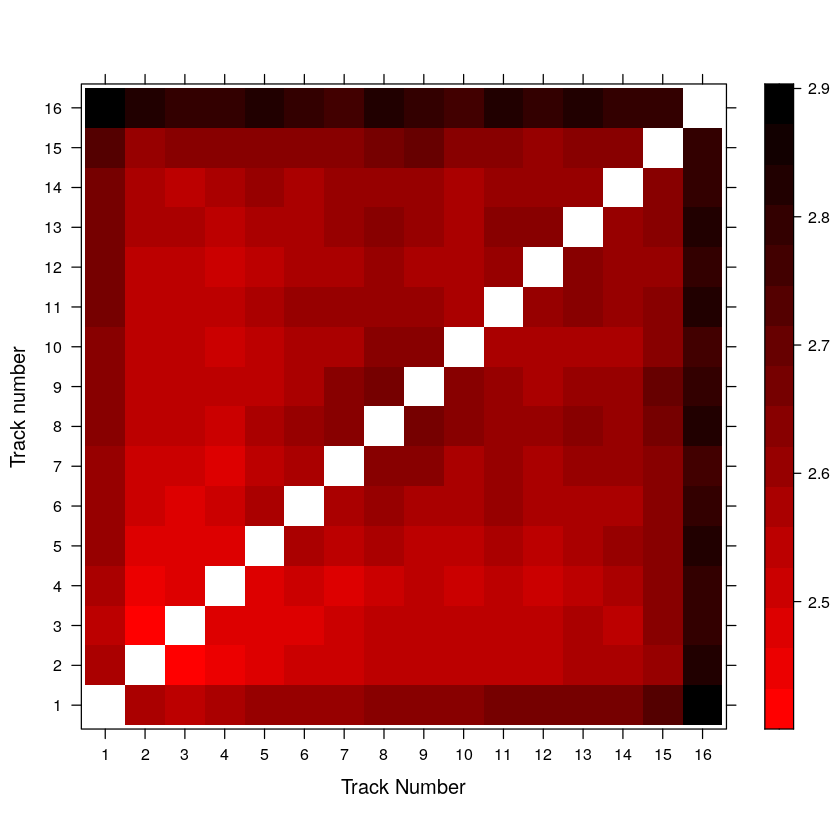

In [27]:
dt = dissim_gen("nn_interpol.csv")
levelplot(dt, col.regions = redblack, xlab = "Track Number", ylab = "Track number")

## Interpretation

Here we see a kind of cluster in the beginning of the albums - coordinates $(7, 7)$. Most interestingly is the fact that dissimilarity scores are higher for tracks 1 and 16. Compare upsampled matrix with [original dissimilarity matrices](https://pasoneto.github.io/doc_suomi/presentations/slides/descriptives.slides.html#/5/0/0), which we calculated by averaging accross albums. Next I'm implementing the permutation test.

# Permutation test

## Procedures:

- Nearest-neighbor interpolation of each album - generates 16x16 matrices;

- Shuffle all upsampled albums within itself;

- Compute dissimilarity matrix for each album;

- Compute the average dissimilarity for each cell of each matrix;

- Record and repeat the process 10k times;

- Compute mean and sd for each cell of the dissimilarity matrix generated throughout the 10k runs. (this gives a total of 10k*number of albums in our sample).

- Subtract the difference between our [original upsampled](#Results) dissimilarity matrix and divide it with the sd.

In [7]:
dt = fread("nn_interpol.csv") %>% dplyr::select(!V1)
colnames(dt) = c("valence", "energy", "loudness", "tempo", "album_id", "track_number")
dt <- split(dt, dt$album_id)

In [8]:
perm = c()
for(j in 1:10000){
    for(i in 1:length(dt)){
        dt[[i]] %<>% mutate(valence  = sample(valence, length(valence)), 
                            energy   = sample(energy, length(energy)),
                            loudness = sample(loudness, length(loudness)),
                            tempo    = sample(tempo, length(tempo)))
        oi = as.matrix(daisy(as.matrix(dt[[i]][, 1:4])))
        oi[oi == 0] <- NA
        perm[[j]] = oi
    }
}

## Results

### Permutated dissimilarity means

Actual permutation happened 4254 times. Even after trying to optimize the code, each dissimilarity matrix took 16 seconds to process. This yiealded a 52 hours-long processing time. 

I was able to let it run for about half of that. This means that I permutated $17249970$ albums ($4254*number\ of\ albums$). This permutation gave us the matrix below, which shows the mean dissimilarity for each pair of tracks.

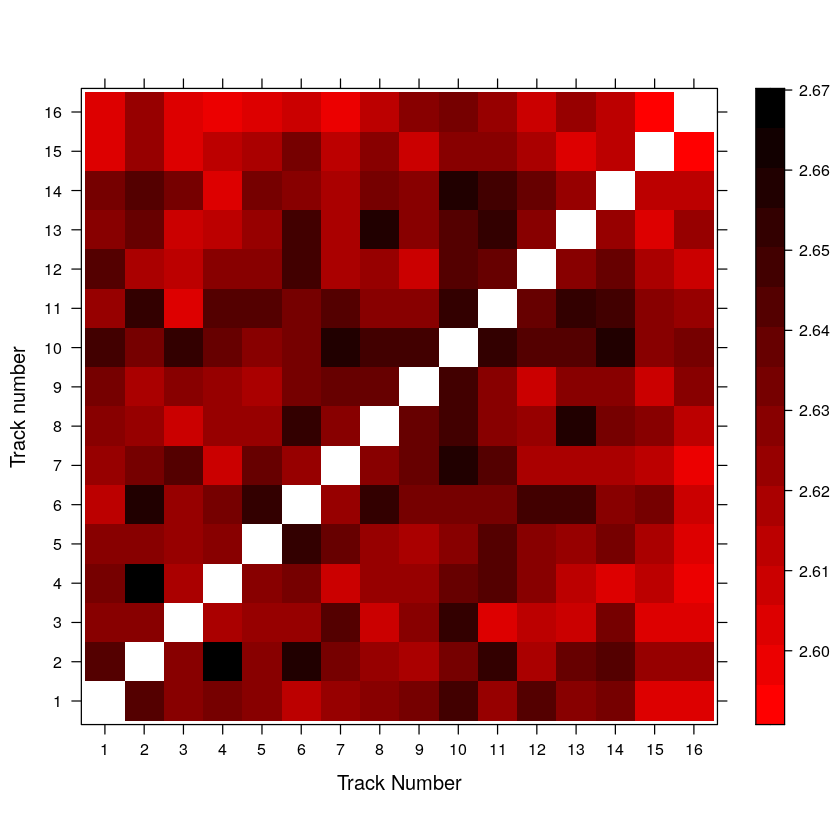

In [28]:
permutated = matrix_parser(perm, mean)
levelplot(permutated, col.regions = redblack, xlab = "Track Number", ylab = "Track number")

### Normalized matrices

Upsampled matrix - mean(permutated matrix) / sd(permutated matrix)


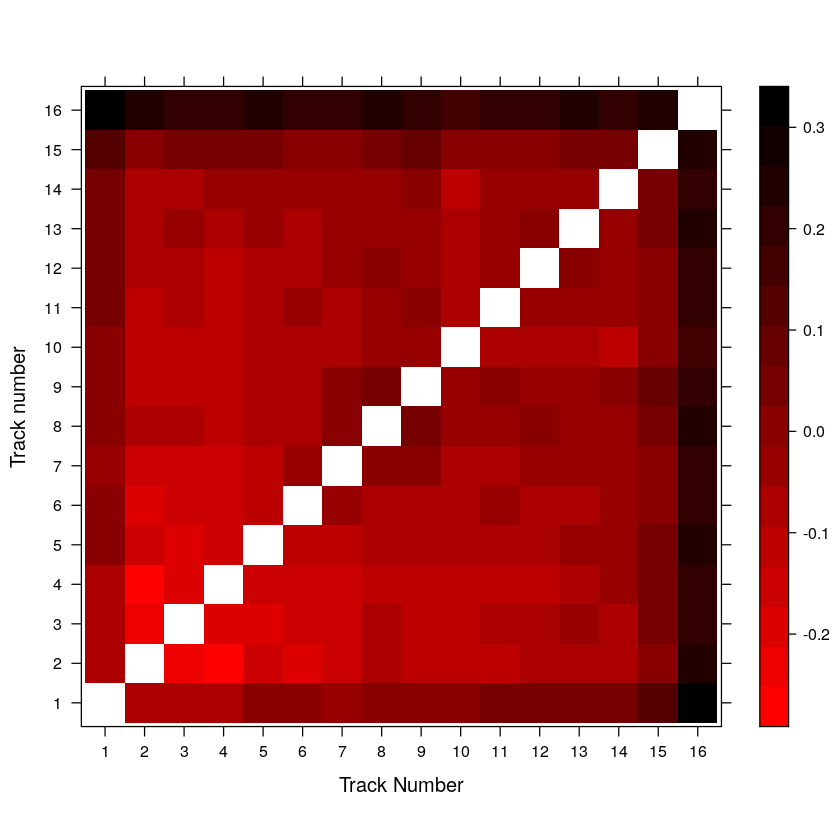

In [29]:
levelplot((dt-permutated)/stdev, col.regions = redblack, xlab = "Track Number", ylab = "Track number")

### Interpretation 

There seems to be two clusters arround $(7, 7)$ and $(10, 10)$. 
These clusters are formed arround the edges of the albums. Perhaps this explains the imbalence in class accuracy that we had in Models 3 and 4.

Most interestingly, in my opinion, is the fact that opening and closing tracks (i.e. 1 and 16) are the most dissimilar ones. 

Note: We can't interpret track numbers so directly, because albums are upsampled to 16. Edges, however, are still edges (tracks 1 and 16 are the first and last tracks of each album).